In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, IterableDataset

import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from typing import Tuple, Dict, List

import pathlib
from pathlib import Path

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from tqdm import tqdm
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/pytorch/data/'
MODEL_PATH = '/content/drive/MyDrive/pytorch/models'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 1 - Prepare Data
1. data is in google drive, so previous code mounts the data
2. standard image classification format
    1. train and test folder
    2. train, test folder contain own folders indicating classes
```
pizza_steak_sushi/
    train/ # <- overall dataset
        pizza/ # <- classes as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image04.jpeg
            image05.jpeg
            ...
        sushi/
            image07.jpeg
            ...
    test/
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image104.jpeg
            image105.jpeg
            ...
        sushi/
            image107.jpeg
            ...
```

#### 1.1 download data and explore directory

In [ ]:
# Setup path to data folder
data_path = Path("/content/drive/MyDrive/pytorch/data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data (images from GitHub)
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak, suhsi data to {image_path}")
  zip_ref.extractall(image_path)

"/content/drive/MyDrive/pytorch/data/pizza_steak_sushi" directory already exists, skipping download


In [ ]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images"
     + f" in \'{dirpath}\'")

There are 2 directories and 0 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi'
There are 3 directories and 0 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/test'
There are 0 directories and 25 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/test/sushi'
There are 3 directories and 0 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train'
There are 0 directories and 78 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in '/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/sushi'


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

#### 1.2 visualize raw images
1. use PIL to open the path
2. `torch.transforms.ToTensor()` to convert to tensor, then permute for matplotlib
3. matplotlib plot

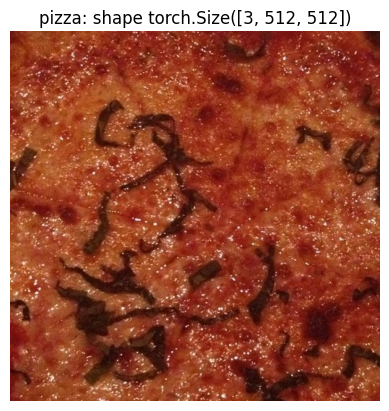

image path: /content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/2451169.jpg
image height: 512
image width: 512
image tensor shape: torch.Size([3, 512, 512])
image tensor: tensor([[[0.4471, 0.4275, 0.4157,  ..., 0.2431, 0.2549, 0.2510],
         [0.4392, 0.4235, 0.4157,  ..., 0.2196, 0.2235, 0.2196],
         [0.4353, 0.4196, 0.4235,  ..., 0.2118, 0.2039, 0.1961],
         ...,
         [0.4471, 0.4588, 0.4549,  ..., 0.5059, 0.5059, 0.4980],
         [0.4549, 0.4588, 0.4745,  ..., 0.5216, 0.5373, 0.5294],
         [0.4941, 0.4824, 0.5020,  ..., 0.5255, 0.5176, 0.4902]],

        [[0.1176, 0.0980, 0.0745,  ..., 0.0863, 0.0902, 0.0863],
         [0.1098, 0.0941, 0.0745,  ..., 0.0627, 0.0588, 0.0549],
         [0.1059, 0.0902, 0.0824,  ..., 0.0549, 0.0471, 0.0392],
         ...,
         [0.0667, 0.0784, 0.0863,  ..., 0.1294, 0.1294, 0.1216],
         [0.0745, 0.0784, 0.0941,  ..., 0.1569, 0.1608, 0.1529],
         [0.1137, 0.1020, 0.1216,  ..., 0.1608, 0.1412, 0.1137]],

   

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
# train/test, then category, then * for image prefixes
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem # parent folder name
img = Image.open(random_image_path)

totensor = ToTensor()
img_tensor = totensor(img)

# img_tensor.permute(1, 2, 0): to H*W*C for matplotlib format
plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis(False)
plt.title(f'{image_class}: shape {img_tensor.shape}')
plt.show()

# meta data:
print('image path:', random_image_path)
print('image height:', img.height)
print('image width:', img.width)

print('image tensor shape:', img_tensor.shape)
print('image tensor:', img_tensor)

#### 1.3 define data transform function

In [ ]:
# image_path_list = list(image_path.glob("*/*/*.jpg"))
# # train/test, then category, then * for image prefixes
# random_image_path = random.choice(image_path_list)
# image_class = random_image_path.parent.stem # parent folder name
# img = Image.open(random_image_path)

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    ToTensor()  # in the end convert to tensor for use, necessary for all images
    # also converts from (0-255) to (0-1)
])

data_transform(img).shape # PIL converted to tensor

torch.Size([3, 64, 64])

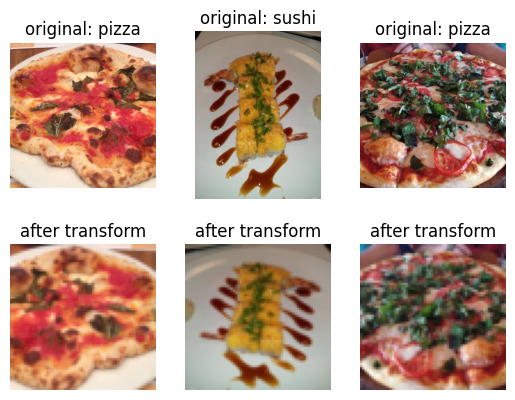

In [ ]:
# compare original and after transform

def plot_transformed_images(image_paths: list, transform, n = 3, seed = None):
    for i in range(n):
        path = random.choice(image_paths)
        img = Image.open(path)
        plt.subplot(2, n, i + 1)
        plt.title(f"original: {path.parent.stem}")
        plt.imshow(totensor(img).permute(1, 2, 0))
        plt.axis(False)

        plt.subplot(2, n, i + n + 1)
        plt.title("after transform")
        plt.imshow(data_transform(img).permute(1, 2, 0))
        plt.axis(False)

plot_transformed_images(image_path_list, data_transform)

#### 1.4 option 1: ImageFolder load data

In [ ]:
# from torchvision import datasets
# by default, it will read the folder name as label
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # transform for data
                                  target_transform = None) # transform for label

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /content/drive/MyDrive/pytorch/data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
train_data.classes, test_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
BATCH_SIZE = 3
train_loader = DataLoader(train_data,
                          batch_size = BATCH_SIZE,
                          num_workers = 1, # number of cpus for loading
                          shuffle = True)

test_loader = DataLoader(test_data,
                         batch_size = BATCH_SIZE,
                         num_workers = 1,
                         shuffle = False)

len(train_loader), len(test_loader)

(75, 25)

In [ ]:
img, label = next(iter(train_loader))

print(f'image shape: {img.shape} -> [batch_size, C, H, W]')
print(f'label shape: {label.shape}')

image shape: torch.Size([3, 3, 64, 64]) -> [batch_size, C, H, W]
label shape: torch.Size([3])


#### 1.5 option 2: custom Dataset class, with no ImageFolder

In [ ]:
list(pathlib.Path(train_dir).glob('*/*.jpg'))

[PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/3441394.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/1968947.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/1899785.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/764429.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/1524655.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/2687575.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/3109486.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/3860002.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/3530210.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train/pizza/2330965.jpg'),
 PosixPath('/content/drive/MyDrive/pytorch/data/pizza_steak_sushi/train

In [ ]:
class CustomDataset(Dataset):

    def __getClasses(self, target_dir: str) -> Tuple[List[str], Dict[str, int]]:
        """
            get classes and dictory back to labels
        """
        classes = sorted([e.name for e in list(os.scandir(target_dir))])
        if len(classes) == 0:
            raise FileNotFoundError(f"Unable to find any classes under {target_dir}, check File Structure")
        idx = 0
        class_to_idx = {}
        for c in classes:
            class_to_idx[c] = idx
            idx += 1
        return classes, class_to_idx

    def __init__(self, target_dir: str, transform = None):
        super().__init__()
        self.target_dir = target_dir
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg')) # get all paths following */*.jpg under target_dir
        self.transform = transform

        self.classes, self.class_to_idx = self.__getClasses(target_dir)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:  # tensor, label = train_data[0]
        img_path = self.paths[idx]
        img = Image.open(img_path) # open image object
        label = self.class_to_idx[img_path.parent.name]
        if self.transform:
            return self.transform(img), label
        else:
            return img, label # untransformed PIL img if no transform

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data = CustomDataset(train_dir, transform = train_transform)
test_data = CustomDataset(test_dir, transform = test_transform)

len(train_data), len(test_data)

(225, 75)

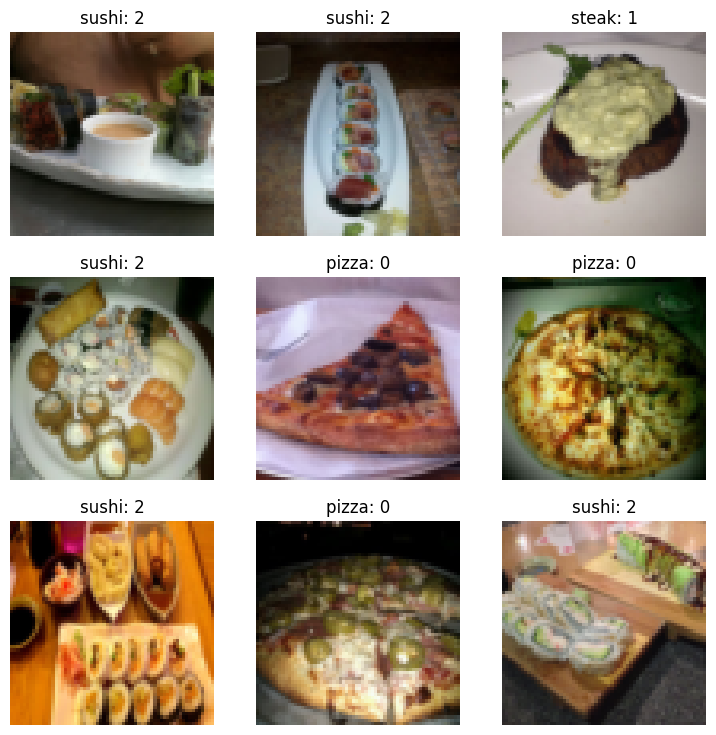

In [ ]:
def displayRandomImages(dataset: Dataset, n: int = 9, seed: int = None):
    if seed:
        random.seed(seed)
    plt.figure(figsize = (9, 9))
    for i in range(n):
        plt.subplot(3, 3, i + 1)
        rd_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[rd_idx]
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis(False)
        plt.title(f"{dataset.classes[label]}: {label}")

displayRandomImages(test_data)

#### 1.6 IterableDataset Example
simply substitute `__getitem__(self, idx)` with `__iter__(self)`

In [ ]:
class CustomIterableDataset(IterableDataset):
    def __getClasses(self, target_dir: str) -> Tuple[List[str], Dict[str, int]]:
        classes = sorted([e.name for e in list(os.scandir(target_dir))])
        if len(classes) == 0:
            raise FileNotFoundError(f"Unable to find any classes under {target_dir}, check File Structure")
        idx = 0
        class_to_idx = {}
        for c in classes:
            class_to_idx[c] = idx
            idx += 1
        return classes, class_to_idx

    def __init__(self, target_dir: str, transform = None):
        super().__init__()
        self.target_dir = target_dir
        self.length = len(list(pathlib.Path(target_dir).glob('*/*.jpg'))) # get all paths following */*.jpg under target_dir
        self.transform = transform

        self.classes, self.class_to_idx = self.__getClasses(target_dir)

    def __len__(self):
        return self.length

    def __iter__(self) -> Tuple[torch.Tensor, int]:  # tensor, label = train_data[0]
        for root, directory_names, fnames in os.walk(self.target_dir):
            if len(directory_names) > 0: # skip root diretory, only get in the category directory
                continue

            for fname in fnames:
                img_path = Path(os.path.join(root, fname))
                img = Image.open(img_path) # open image object
                label = self.class_to_idx[img_path.parent.name]
                if self.transform:
                    yield self.transform(img), label
                else:
                    yield img, label # untransformed PIL img if no transform

In [ ]:
train_data_iterable = CustomIterableDataset(train_dir, transform = train_transform)
next(iter(train_data_iterable))

(tensor([[[0.9216, 0.9137, 0.8941,  ..., 0.9137, 0.9098, 0.9098],
          [0.9255, 0.9098, 0.8863,  ..., 0.9176, 0.9176, 0.9176],
          [0.9255, 0.9137, 0.8667,  ..., 0.9255, 0.9216, 0.9216],
          ...,
          [0.6235, 0.6196, 0.7020,  ..., 0.1961, 0.2510, 0.2118],
          [0.8353, 0.7647, 0.6824,  ..., 0.2275, 0.2353, 0.1922],
          [0.8863, 0.8784, 0.8510,  ..., 0.2471, 0.2157, 0.1843]],
 
         [[0.9255, 0.9176, 0.8863,  ..., 0.9098, 0.9059, 0.9059],
          [0.9216, 0.9020, 0.8784,  ..., 0.9098, 0.9098, 0.9137],
          [0.9216, 0.9020, 0.8588,  ..., 0.9255, 0.9216, 0.9216],
          ...,
          [0.5882, 0.5686, 0.6392,  ..., 0.1804, 0.2471, 0.2039],
          [0.8353, 0.7451, 0.6549,  ..., 0.2196, 0.2314, 0.1765],
          [0.8941, 0.8745, 0.8510,  ..., 0.2431, 0.2078, 0.1765]],
 
         [[0.9412, 0.9216, 0.8902,  ..., 0.9059, 0.8980, 0.8980],
          [0.9216, 0.8980, 0.8588,  ..., 0.9098, 0.9137, 0.9137],
          [0.9098, 0.8980, 0.8392,  ...,

#### 1.7 Set up DataLoader and explore more transforms for augmentation

In [ ]:
BATCH_SIZE = 3

train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

len(train_loader), len(test_loader)

(75, 25)

In [ ]:
batch, labels = next(iter(train_loader))
batch.shape

torch.Size([3, 3, 64, 64])

In [ ]:
train_transform_trivial_augment = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins = 32),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform_trivial_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

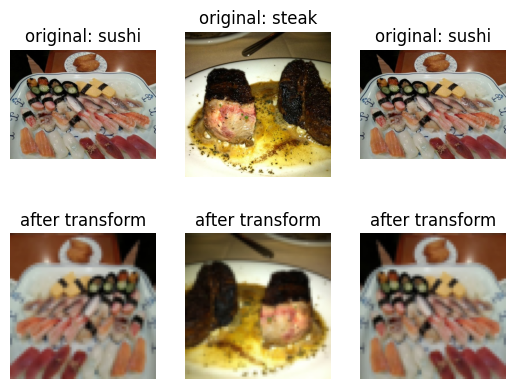

In [ ]:
images = random.sample(list(image_path.glob('*/*/*.jpg')), 3)
plot_transformed_images(images, train_transform_trivial_augment, 3)

### 2 - Model 0: No Data Augmentation (overfit)

#### 2.1 define simple transform

In [ ]:
transform_simple = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_simple = CustomDataset(train_dir, transform_simple)
test_data_simple = CustomDataset(test_dir, transform_simple)

BATCH_SIZE = 32
train_loader_simple = DataLoader(train_data_simple, batch_size = BATCH_SIZE,
                                 shuffle = True)
test_loader_simple = DataLoader(test_data_simple, batch_size = BATCH_SIZE,
                                shuffle = False)


#### 2.2 define model

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8,
                      kernel_size = (3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 8,
                      kernel_size = (3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = 8, out_channels = 8,
                      kernel_size = (3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 8,
                      kernel_size = (3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 2048, out_features = 16), # 2048 tested
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x: torch.Tensor):
        res = self.conv_block1(x)
        res = self.conv_block2(res)
        res = self.mlp(res)
        return res

In [ ]:
model0 = CNN().to(device)

In [ ]:
sample_batch, sample_label = next(iter(train_loader_simple))
model0(sample_batch.to(device)).shape

torch.Size([32, 3])

In [ ]:
model0_path = Path(MODEL_PATH) / '4_Custom_PyTorch_Dataset_Model0.pth'
model0_history_path = Path(MODEL_PATH) / '4_Custom_PyTorch_Dataset_Model0_history.txt'
if model0_path.is_file():
    print('load models')
    model0.load_state_dict(torch.load(model0_path, map_location = torch.device(device)))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model0.parameters(), lr = 0.001)

load models


<ipython-input-34-c3ff87d75c2a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model0.load_state_dict(torch.load(model0_path, map_location = torch.device(device)))


#### 2.3 torchinfo to see model information
this can also reveal the information for output of flatten layer, does so by doing a sample pass

In [ ]:
torchinfo.summary(model0,input_size = sample_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 3]                   --
├─Sequential: 1-1                        [32, 8, 32, 32]           --
│    └─Conv2d: 2-1                       [32, 8, 64, 64]           224
│    └─ReLU: 2-2                         [32, 8, 64, 64]           --
│    └─Conv2d: 2-3                       [32, 8, 64, 64]           584
│    └─ReLU: 2-4                         [32, 8, 64, 64]           --
│    └─MaxPool2d: 2-5                    [32, 8, 32, 32]           --
├─Sequential: 1-2                        [32, 8, 16, 16]           --
│    └─Conv2d: 2-6                       [32, 8, 32, 32]           584
│    └─ReLU: 2-7                         [32, 8, 32, 32]           --
│    └─Conv2d: 2-8                       [32, 8, 32, 32]           584
│    └─ReLU: 2-9                         [32, 8, 32, 32]           --
│    └─MaxPool2d: 2-10                   [32, 8, 16, 16]           --
├─Sequentia

#### 2.4 train model

In [ ]:
def train_model(model, loss_fn, optimizer, train_loader, eval_loader,
                EPOCH = 3, device = device, model_save_path = None,
                history_save_path = None):
    history = {
        'train loss': [],
        'train acc': [],
        'eval loss': [],
        'eval acc': [],
    }

    for epoch in range(EPOCH):
        print(f'---EPOCH {epoch}---')
        train_loss = 0
        train_acc = 0
        eval_loss = 0
        eval_acc = 0

        model.train()
        for X_train, y_train in tqdm(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            y_train_pred = model(X_train)
            loss_train = loss_fn(y_train_pred, y_train)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            train_loss += loss_train.item()
            train_acc += accuracy_fn(y_train_pred.argmax(dim = 1), y_train)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        with torch.inference_mode():
            for X_eval, y_eval in tqdm(eval_loader):
                X_eval = X_eval.to(device)
                y_eval = y_eval.to(device)

                y_eval_pred = model(X_eval)
                loss_eval = loss_fn(y_eval_pred, y_eval)

                eval_loss += loss_eval.item()
                eval_acc += accuracy_fn(y_eval_pred.argmax(dim = 1), y_eval)
        eval_loss /= len(eval_loader)
        eval_acc /= len(eval_loader)

        print(f'train loss: {train_loss:.4f} | train accuracy: {train_acc:.4f}')
        print(f'eval loss: {eval_loss:.4f} | eval accuracy: {eval_acc:.4f}')
        history['train loss'].append(train_loss)
        history['train acc'].append(train_acc)
        history['eval loss'].append(eval_loss)
        history['eval acc'].append(eval_acc)

    if model_save_path:
        print(f'SAVING MODEL TO {model_save_path.name}...')
        torch.save(model.state_dict(), model_save_path)

    if history_save_path:
        print(f'SAVING HISTORY TO {history_save_path.name}...')
        with open(history_save_path, 'w') as f:
            json.dump(history, f)


In [ ]:
# train_model(model0, loss_fn, optimizer, train_loader_simple,
#             test_loader_simple, model_save_path = model0_path,
#             history_save_path = model0_history_path, EPOCH = 30)

#### 2.5 eval model

In [ ]:
def eval_model(model, loader, loss_fn, accuracy_fn, device = device):
    model.eval()
    eval_loss, eval_acc = 0, 0
    with torch.inference_mode():
        for X, y in tqdm(loader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            eval_acc += accuracy_fn(y_pred.argmax(dim = 1), y)
    eval_loss /= len(loader)
    eval_acc /= len(loader)

    return {
        "model_name": model.__class__.__name__,
        "loss": eval_loss,
        "accuracy": eval_acc
    }

eval_model(model0, test_loader_simple, loss_fn, accuracy_fn)

100%|██████████| 3/3 [00:22<00:00,  7.57s/it]


{'model_name': 'CNN',
 'loss': 1.1749972899754841,
 'accuracy': 0.38257575757575757}

In [ ]:
model0_history = {}
with open(model0_history_path, 'r') as f:
    model0_history = json.loads(f.read())

model0_history

{'train loss': [1.0959653854370117,
  1.1119243204593658,
  1.0910394042730331,
  1.1053723692893982,
  1.0989892780780792,
  1.0819491744041443,
  1.0539164543151855,
  1.0263327583670616,
  0.947177343070507,
  0.8977101445198059,
  0.8780218884348869,
  0.9039783924818039,
  0.8481695204973221,
  0.7693987153470516,
  0.7419236754067242,
  0.7570838369429111,
  0.7309756297618151,
  0.7469259761273861,
  0.8017934039235115,
  0.9075853899121284,
  0.8295148983597755,
  0.8250977471470833,
  0.7504438832402229,
  0.7660544589161873,
  0.6651700232177973,
  0.785975843667984,
  0.7882479280233383,
  0.6164920143492054,
  0.6343357227742672,
  0.6217094613239169],
 'train acc': [0.40234375,
  0.28125,
  0.40234375,
  0.28125,
  0.3046875,
  0.3671875,
  0.328125,
  0.4140625,
  0.5703125,
  0.61328125,
  0.62890625,
  0.59765625,
  0.6015625,
  0.6328125,
  0.6484375,
  0.67578125,
  0.6640625,
  0.6953125,
  0.71484375,
  0.5390625,
  0.7109375,
  0.734375,
  0.6640625,
  0.66015625,


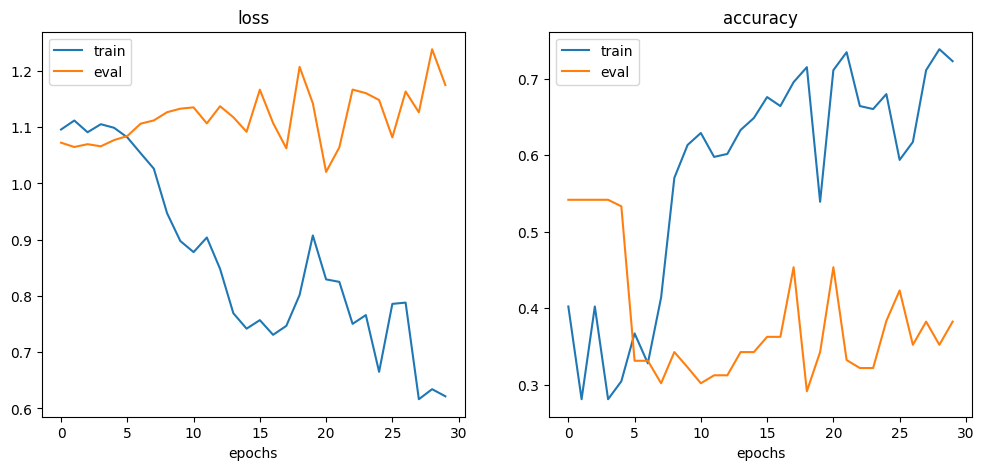

In [ ]:
def plot_loss_curves(history: Dict[str, List[float]]):
    train_loss = history['train loss']
    eval_loss = history['eval loss']

    train_accuracy = history['train acc']
    eval_accuracy = history['eval acc']

    epochs = range(len(train_loss))

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = 'train')
    plt.plot(epochs, eval_loss, label = 'eval')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label = 'train')
    plt.plot(epochs, eval_accuracy, label = 'eval')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

    plt.show()

plot_loss_curves(model0_history)

### 3 - Model 1: With Data Augmentation (better against overfitting)

#### 3.1 define transformations

In [ ]:
train_transform_augment = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform_augment = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

train_data_augmented = CustomDataset(train_dir, transform = train_transform_augment)
eval_data_augmented = CustomDataset(test_dir, transform = test_transform_augment)

BATCH_SIZE = 32
train_loader_augmented = DataLoader(train_data_augmented, batch_size = BATCH_SIZE, shuffle = True)
eval_loader_augmented = DataLoader(eval_data_augmented, batch_size = BATCH_SIZE, shuffle = False)

#### 3.2 define model

In [ ]:
model1 = CNN().to(device)
model1_path = pathlib.Path(MODEL_PATH) / '4_Custom_PyTorch_Dataset_Model1.pth'
model1_history_path = pathlib.Path(MODEL_PATH) / '4_Custom_PyTorch_Dataset_Model1_history.txt'

if model1_path.is_file():
    print('loading model')
    model1.load_state_dict(torch.load(model1_path, map_location = torch.device(device)))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model1.parameters(), lr = 0.001)

loading model


<ipython-input-42-8b107c6e5b79>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(model1_path, map_location = torch.device(device)))


#### 3.3 train model

In [ ]:
# train_model(model1, loss_fn, optimizer, train_loader_augmented,
#             eval_loader_augmented, EPOCH = 30, device = device,
#             model_save_path = model1_path, history_save_path = model1_history_path)

#### 3.4 eval model

In [ ]:
eval_model(model1, eval_loader_augmented, loss_fn, accuracy_fn)

100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


{'model_name': 'CNN',
 'loss': 1.0121170282363892,
 'accuracy': 0.43371212121212127}

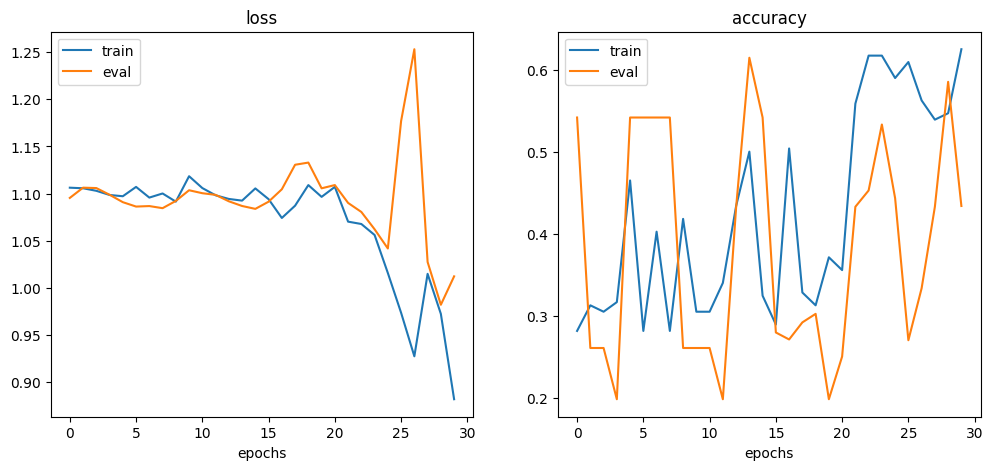

In [ ]:
model1_history = {}
with open(model1_history_path, 'r') as f:
    model1_history = json.loads(f.read())

plot_loss_curves(model1_history)

### 4 - Compare Model Results

#### 4.1 compare two models across epochs

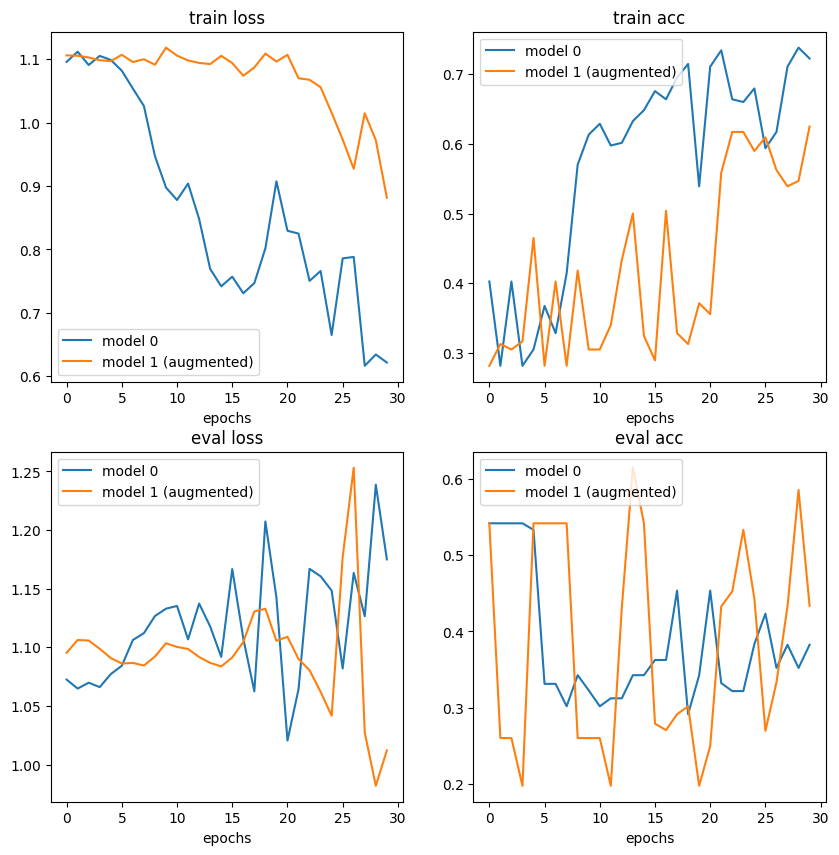

In [ ]:
def compare_histories(history1: Dict[str, List[float]],
                      history2: Dict[str, List[float]]):
    plt.figure(figsize = (10, 10))
    epochs = range(len(history1['train acc']))

    for i in range(len(history1)):
        metric_name = list(model0_history.keys())[i]

        plt.subplot(2, 2, i + 1)
        plt.title(metric_name)
        plt.plot(epochs, history1[metric_name], label = 'model 0')
        plt.plot(epochs, history2[metric_name], label = 'model 1 (augmented)')
        plt.xlabel('epochs')
        plt.legend()

    plt.show()

compare_histories(model0_history, model1_history)

#### 4.2 custom image classification

In [ ]:
# request an image and then classify
# if doesn't work anymore, then upload a randomone
import requests
custom_image_path = pathlib.Path(DATA_PATH) / "pizza-dad.jpeg"
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true')
        print('download file as it does not exist')
        f.write(request.content)
else:
    print('file exists, skip download')

file exists, skip download


In [ ]:
classes = train_data_augmented.classes
classes

['pizza', 'steak', 'sushi']

(-0.5, 3023.5, 4031.5, -0.5)

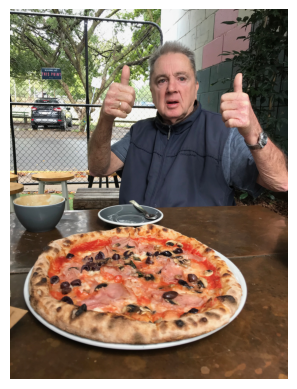

In [ ]:
img = Image.open(custom_image_path)
plt.imshow(img)
plt.axis(False)

'pizza'

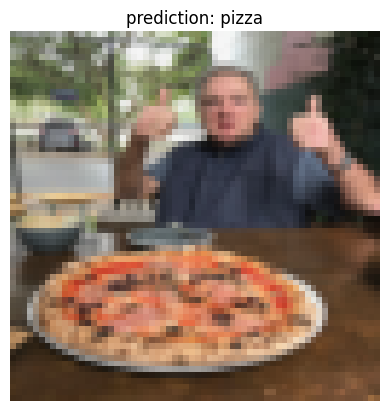

In [ ]:
def classify_image(path: Path, model: nn.Module, classes: List[str],
                   transform: torchvision.transforms.transforms.Compose,
                   device = device):

    img = Image.open(path)
    tensor = transform(img).to(device)

    predprob = 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        predprob = model(tensor.unsqueeze(dim = 0))

    pred_name = classes[predprob.squeeze().argmax()]

    # plot result
    plt.imshow(tensor.permute(1, 2, 0))
    plt.title(f'prediction: {pred_name}')
    plt.axis(False)

    return pred_name

# prediction: correct
classify_image(custom_image_path, model1, classes, test_transform_augment)